In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import string
import random
import matplotlib.pyplot as plt
import time
from google.colab import drive
import os
import unidecode
import string


In [2]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
drive.mount('/content/drive')

os.chdir('/content/drive/My Drive/colab')


def load_data(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        text = unidecode.unidecode(file.read())
    return text


def tokenize(text):
    chars = string.printable
    char_to_idx = {char: idx for idx, char in enumerate(chars)}
    idx_to_char = {idx: char for idx, char in enumerate(chars)}
    return char_to_idx, idx_to_char, len(chars)


text = load_data('input.txt')
char_to_idx, idx_to_char, vocab_size = tokenize(text)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.encoder = nn.Embedding(input_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, n_layers, batch_first=True)
        self.decoder = nn.Linear(hidden_size, output_size)

    def forward(self, input, hidden):
        output = self.encoder(input)
        output, hidden = self.lstm(output, hidden)
        output = self.decoder(output)
        return output, hidden

    def init_hidden(self):
        return (torch.zeros(self.n_layers, 1, self.hidden_size).to(device),
                torch.zeros(self.n_layers, 1, self.hidden_size).to(device))

class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers):
        super(GRUModel, self).__init__()
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.encoder = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers, batch_first=True)
        self.decoder = nn.Linear(hidden_size, output_size)

    def forward(self, input, hidden):
        output = self.encoder(input)
        output, hidden = self.gru(output, hidden)
        output = self.decoder(output)
        return output, hidden

    def init_hidden(self):
        return torch.zeros(self.n_layers, 1, self.hidden_size).to(device)


In [5]:
def random_chunk(text, chunk_len):
    start_index = random.randint(0, len(text) - chunk_len - 1)
    end_index = start_index + chunk_len + 1
    return text[start_index:end_index]

def char_tensor(string, char_to_idx):
    tensor = torch.zeros(len(string)).long()
    for c in range(len(string)):
        tensor[c] = char_to_idx[string[c]]
    return tensor

def random_training_set(chunk_len, text, char_to_idx):
    chunk = random_chunk(text, chunk_len)
    inp = char_tensor(chunk[:-1], char_to_idx)
    target = char_tensor(chunk[1:], char_to_idx)
    return inp.to(device), target.to(device)


In [6]:
def train(model, optimizer, criterion, chunk_len, text, char_to_idx, n_epochs, print_every=100):
    losses = []
    for epoch in range(1, n_epochs + 1):
        inp, target = random_training_set(chunk_len, text, char_to_idx)
        hidden = model.init_hidden()
        model.zero_grad()
        loss = 0

        for c in range(chunk_len):
            output, hidden = model(inp[c].view(1, -1), hidden)
            loss += criterion(output.view(1, -1), target[c].view(1))

        loss.backward()
        optimizer.step()

        losses.append(loss.item() / chunk_len)

        if epoch % print_every == 0:
            print(f'Epoch: {epoch}, Loss: {loss.item() / chunk_len}')

    return losses


In [7]:
def evaluate(model, prime_str, char_to_idx, idx_to_char, predict_len, temperature=0.8):
    hidden = model.init_hidden()
    prime_input = char_tensor(prime_str, char_to_idx).to(device)
    predicted = prime_str

    for p in range(len(prime_str) - 1):
        _, hidden = model(prime_input[p].view(1, -1), hidden)

    inp = prime_input[-1]

    for p in range(predict_len):
        output, hidden = model(inp.view(1, -1), hidden)
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]
        predicted_char = idx_to_char[top_i.item()]
        predicted += predicted_char
        inp = char_tensor(predicted_char, char_to_idx).to(device)

    return predicted


In [18]:

n_epochs_1 = 1500
hidden_size_1 = 200
n_layers_1 = 3
learning_rate_1 = 0.005
temperature_1 = 0.8
chunk_len_1 = 200


n_epochs_2 = 1500
hidden_size_2 = 100
n_layers_2 = 3
learning_rate_2 = 0.005
temperature_2 = 0.6
chunk_len_2 = 300


n_epochs_3 = 1500
hidden_size_3 = 300
n_layers_3 = 3
learning_rate_3 = 0.0005
temperature_3 = 0.7
chunk_len_3 = 100


n_epochs_4 = 1500
hidden_size_4 = 500
n_layers_4 = 3
learning_rate_4 = 0.0005
temperature_4 = 0.5
chunk_len_4 = 500


lstm_model_1 = LSTMModel(vocab_size, hidden_size_1, vocab_size, n_layers_1).to(device)
gru_model_1 = GRUModel(vocab_size, hidden_size_1, vocab_size, n_layers_1).to(device)
lstm_model_2 = LSTMModel(vocab_size, hidden_size_2, vocab_size, n_layers_2).to(device)
gru_model_2 = GRUModel(vocab_size, hidden_size_2, vocab_size, n_layers_2).to(device)
lstm_model_3 = LSTMModel(vocab_size, hidden_size_3, vocab_size, n_layers_3).to(device)
gru_model_3 = GRUModel(vocab_size, hidden_size_3, vocab_size, n_layers_3).to(device)
lstm_model_4 = LSTMModel(vocab_size, hidden_size_4, vocab_size, n_layers_4).to(device)
gru_model_4 = GRUModel(vocab_size, hidden_size_4, vocab_size, n_layers_4).to(device)


criterion = nn.CrossEntropyLoss()
lstm_optimizer_1 = optim.Adam(lstm_model_1.parameters(), lr=learning_rate_1)
gru_optimizer_1 = optim.Adam(gru_model_1.parameters(), lr=learning_rate_1)


lstm_optimizer_2 = optim.Adam(lstm_model_2.parameters(), lr=learning_rate_2)
gru_optimizer_2 = optim.Adam(gru_model_2.parameters(), lr=learning_rate_2)


lstm_optimizer_3 = optim.Adam(lstm_model_3.parameters(), lr=learning_rate_3)
gru_optimizer_3 = optim.Adam(gru_model_3.parameters(), lr=learning_rate_3)


lstm_optimizer_4 = optim.Adam(lstm_model_4.parameters(), lr=learning_rate_4)
gru_optimizer_4 = optim.Adam(gru_model_4.parameters(), lr=learning_rate_4)


def timed_train(model, optimizer, criterion, chunk_len, text, char_to_idx, n_epochs):
    start_time = time.time()
    losses = train(model, optimizer, criterion, chunk_len, text, char_to_idx, n_epochs)
    end_time = time.time()
    training_time = end_time - start_time
    return losses, training_time


print("Training LSTM Model for Iteration 1")
lstm_losses_1, lstm_time_1 = timed_train(lstm_model_1, lstm_optimizer_1, criterion, chunk_len_1, text, char_to_idx, n_epochs_1)
print("Training GRU Model for Iteration 1")
gru_losses_1, gru_time_1 = timed_train(gru_model_1, gru_optimizer_1, criterion, chunk_len_1, text, char_to_idx, n_epochs_1)

print("Training LSTM Model for Iteration 2")
lstm_losses_2, lstm_time_2 = timed_train(lstm_model_2, lstm_optimizer_2, criterion, chunk_len_2, text, char_to_idx, n_epochs_2)
print("Training GRU Model for Iteration 2")
gru_losses_2, gru_time_2 = timed_train(gru_model_2, gru_optimizer_2, criterion, chunk_len_2, text, char_to_idx, n_epochs_2)


print("Training LSTM Model for Iteration 3")
lstm_losses_3, lstm_time_3 = timed_train(lstm_model_3, lstm_optimizer_3, criterion, chunk_len_3, text, char_to_idx, n_epochs_3)
print("Training GRU Model for Iteration 3")
gru_losses_3, gru_time_3 = timed_train(gru_model_3, gru_optimizer_3, criterion, chunk_len_3, text, char_to_idx, n_epochs_3)


print("Training LSTM Model for Iteration 4")
lstm_losses_4, lstm_time_4 = timed_train(lstm_model_4, lstm_optimizer_4, criterion, chunk_len_4, text, char_to_idx, n_epochs_4)
print("Training GRU Model for Iteration 4")
gru_losses_4, gru_time_4 = timed_train(gru_model_4, gru_optimizer_4, criterion, chunk_len_4, text, char_to_idx, n_epochs_4)


print(f"LSTM Training Time for Iteration 1: {lstm_time_1:.2f} seconds")
print(f"GRU Training Time for Iteration 1: {gru_time_1:.2f} seconds")
print(f"LSTM Training Time for Iteration 2: {lstm_time_2:.2f} seconds")
print(f"GRU Training Time for Iteration 2: {gru_time_2:.2f} seconds")
print(f"LSTM Training Time for Iteration 3: {lstm_time_3:.2f} seconds")
print(f"GRU Training Time for Iteration 3: {gru_time_3:.2f} seconds")
print(f"LSTM Training Time for Iteration 4: {lstm_time_4:.2f} seconds")
print(f"GRU Training Time for Iteration 4: {gru_time_4:.2f} seconds")


Training LSTM Model for Iteration 1
Epoch: 100, Loss: 2.9770684814453126
Epoch: 200, Loss: 2.767892150878906
Epoch: 300, Loss: 2.5788702392578124
Epoch: 400, Loss: 1.9795401000976562
Epoch: 500, Loss: 1.9314262390136718
Epoch: 600, Loss: 1.9637429809570313
Epoch: 700, Loss: 1.8958718872070313
Epoch: 800, Loss: 1.6611358642578125
Epoch: 900, Loss: 1.6502403259277343
Epoch: 1000, Loss: 1.8946849060058595
Epoch: 1100, Loss: 1.7554426574707032
Epoch: 1200, Loss: 1.6765972900390624
Epoch: 1300, Loss: 1.7551551818847657
Epoch: 1400, Loss: 1.7873802185058594
Epoch: 1500, Loss: 1.7344189453125
Training GRU Model for Iteration 1
Epoch: 100, Loss: 2.140283508300781
Epoch: 200, Loss: 2.229479217529297
Epoch: 300, Loss: 1.9164649963378906
Epoch: 400, Loss: 1.993505859375
Epoch: 500, Loss: 1.8562704467773437
Epoch: 600, Loss: 1.887843475341797
Epoch: 700, Loss: 1.8479518127441406
Epoch: 800, Loss: 1.6271464538574218
Epoch: 900, Loss: 1.8177752685546875
Epoch: 1000, Loss: 1.965796661376953
Epoch: 11

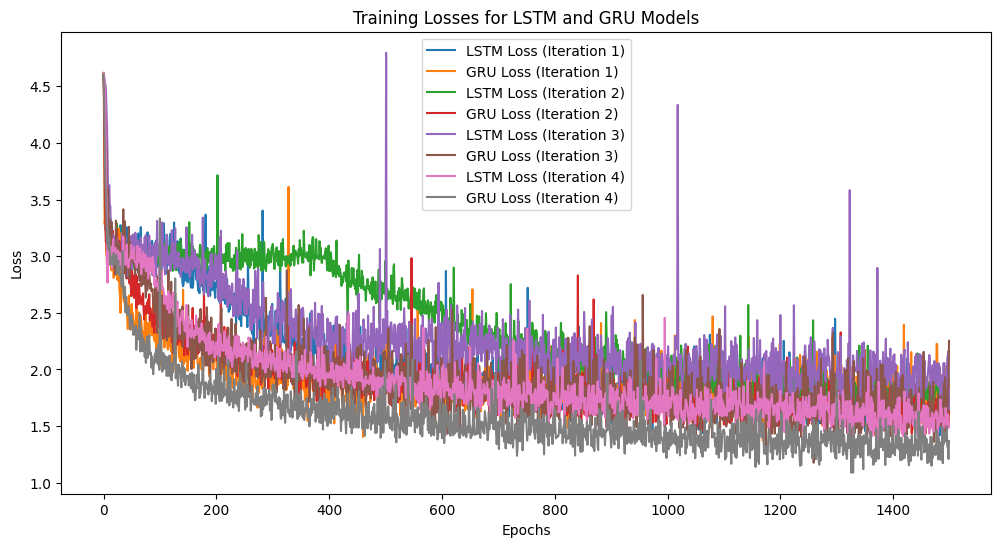

LSTM Model Output for Iteration 1:
Sherlock that pocely corved a drestly man man
     deeleced remased he backing here for toned tamed our a fortion. Wats of a maceshory a somessation, or to me,
     prom he was a mink for in't dorge that the mespons imy me seafery scome day retore at what a pas, but him enating on to one of the could I man mrerniNable would is was was heave bed upon so or the parke upenah said or wands been see one, and my mave deady not ever
     to deached is lady the was of to 1'Frains wos merpot was is meing the can

GRU Model Output for Iteration 1:
Sherlock beindon the can? Other a for in that, and we wand, and be with halles warkcoass in as to dow and his his
     over hag neet that or a that was in an alsed twreet a bettanthing it doning the had gind was in that the has that the Saling a gurew bote the mast and the bove thelas come -now tattered we kproice. Shere was
     acasme we handed was in that a was sit was of it. The was an has the at ansone an
     to

In [20]:
plt.figure(figsize=(12, 6))
plt.plot(lstm_losses_1, label='LSTM Loss (Iteration 1)')
plt.plot(gru_losses_1, label='GRU Loss (Iteration 1)')
plt.plot(lstm_losses_2, label='LSTM Loss (Iteration 2)')
plt.plot(gru_losses_2, label='GRU Loss (Iteration 2)')
plt.plot(lstm_losses_3, label='LSTM Loss (Iteration 3)')
plt.plot(gru_losses_3, label='GRU Loss (Iteration 3)')
plt.plot(lstm_losses_4, label='LSTM Loss (Iteration 4)')
plt.plot(gru_losses_4, label='GRU Loss (Iteration 4)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Losses for LSTM and GRU Models')
plt.show()


print("LSTM Model Output for Iteration 1:")
print(evaluate(lstm_model_1, 'Sherlock', char_to_idx, idx_to_char, 500, temperature_1))
print("\nGRU Model Output for Iteration 1:")
print(evaluate(gru_model_1, 'Sherlock', char_to_idx, idx_to_char, 500, temperature_1))

print("\nLSTM Model Output for Iteration 2:")
print(evaluate(lstm_model_2, 'Sherlock', char_to_idx, idx_to_char, 500, temperature_2))
print("\nGRU Model Output for Iteration 2:")
print(evaluate(gru_model_2, 'Sherlock', char_to_idx, idx_to_char, 500, temperature_2))

print("\nLSTM Model Output for Iteration 3:")
print(evaluate(lstm_model_3, 'Sherlock', char_to_idx, idx_to_char, 500, temperature_3))
print("\nGRU Model Output for Iteration 3:")
print(evaluate(gru_model_3, 'Sherlock', char_to_idx, idx_to_char, 500, temperature_3))

print("\nLSTM Model Output for Iteration 4:")
print(evaluate(lstm_model_4, 'Sherlock', char_to_idx, idx_to_char, 500, temperature_4))
print("\nGRU Model Output for Iteration 4:")
print(evaluate(gru_model_4, 'Sherlock', char_to_idx, idx_to_char, 500, temperature_4))
